In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import wandb
api = wandb.Api()

In [3]:
root = "anands/sparse-rtrl"

In [4]:
# runs = api.runs(root)

In [5]:
# run = api.run("anands/sparse-rtrl/3qypiu9p")
# sp = run.scan_history()

In [6]:
# list(sp)[0].keys()

In [7]:
# [r['train.step'] for r in sp if 'train.step' in r]

In [20]:
runs = api.runs(root, {
    "tags": "sparsity-runs"
    # "tags": "no-activity-sparsity"
})
print(len(list(runs)))

50


In [21]:
sps_d = {}
configs_d = {}
summaries_d = {}

for run in runs:
    # run = api.run(f"{root}/{nn}")
    sp = run.scan_history()
    cfg = run.config
    sry = run.summary
    sps_d.setdefault(cfg['weight_sparsity'], []).append(sp)
    configs_d.setdefault(cfg['weight_sparsity'], []).append(cfg)
    summaries_d.setdefault(cfg['weight_sparsity'], []).append(sry)

In [22]:
len(sps_d), len(sps_d[0.1])

(10, 5)

In [23]:
def stack(sps, key):
    a = [[r[key] for r in sp if key in r] for sp in sps]
    assert len(a) > 0, f"{key} has no entries"
    lens = [len(l) for l in a]
    # stacked_a = np.stack([l[:np.min(lens) - 1] for l in a])
    stacked_a = np.stack(a)
    return stacked_a

In [24]:
stacked_vals = {}
stacked_means = {}
stacked_stds = {}

for wsp, sps in sps_d.items():
    print(wsp)
    sps = [list(sp) for sp in sps]
    # print(sp[0])
    stacked_step = stack(sps, 'train.step')
    stacked_loss = stack(sps, 'train.loss')
    stacked_val_acc = stack(sps, 'validation.accuracy')
    stacked_val_step = stack(sps, 'validation.step')
    stacked_mean_M_sparsity = stack(sps, 'train.mean_M_sparsity')
    # stacked_cumsum_mean_M_sparsity = np.cumsum(stacked_mean_M_sparsity, axis=1)
    stacked_mean_state_sparsity = stack(sps, 'train.mean_state_sparsity')
    stacked_cumsum_mean_M_density = stack(sps, 'train.cum_mean_M_density')
    # print(stacked_cumsum_mean_M_sparsity.shape)
    stacked_vals[wsp] = dict(loss=stacked_loss, 
                             mean_M_sparsity=stacked_mean_M_sparsity,
                             cumsum_mean_M_density=stacked_cumsum_mean_M_density, 
                             mean_state_sparsity=stacked_mean_state_sparsity,
                             val_acc=stacked_val_acc, val_step=stacked_val_step,
                             step=stacked_step)
    stacked_means[wsp] = dict(loss=np.mean(stacked_loss, axis=0), 
                              mean_M_sparsity=np.mean(stacked_mean_M_sparsity, axis=0),
                              cumsum_mean_M_density=np.mean(stacked_cumsum_mean_M_density, axis=0),
                              mean_state_sparsity=np.mean(stacked_mean_state_sparsity, axis=0),
                              val_acc=np.mean(stacked_val_acc, axis=0), 
                              val_step=np.mean(stacked_val_step, axis=0),
                              step=np.mean(stacked_step, axis=0))
    stacked_stds[wsp] = dict(loss=np.std(stacked_loss, axis=0), 
                              mean_M_sparsity=np.std(stacked_mean_M_sparsity, axis=0),
                              cumsum_mean_M_density=np.std(stacked_cumsum_mean_M_density, axis=0),
                              mean_state_sparsity=np.std(stacked_mean_state_sparsity, axis=0),
                              val_acc=np.std(stacked_val_acc, axis=0), 
                              val_step=np.std(stacked_val_step, axis=0),
                              step=np.std(stacked_step, axis=0))

0.9
0.8


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


0.7
0.6
0.5
0.4
0.3
0.2
0.1
0


In [25]:
stacked_means[0]['cumsum_mean_M_density']

array([9.51749206e-02, 1.93738663e-01, 2.88092875e-01, ...,
       6.11128821e+02, 6.11554095e+02, 6.11979749e+02])

In [26]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

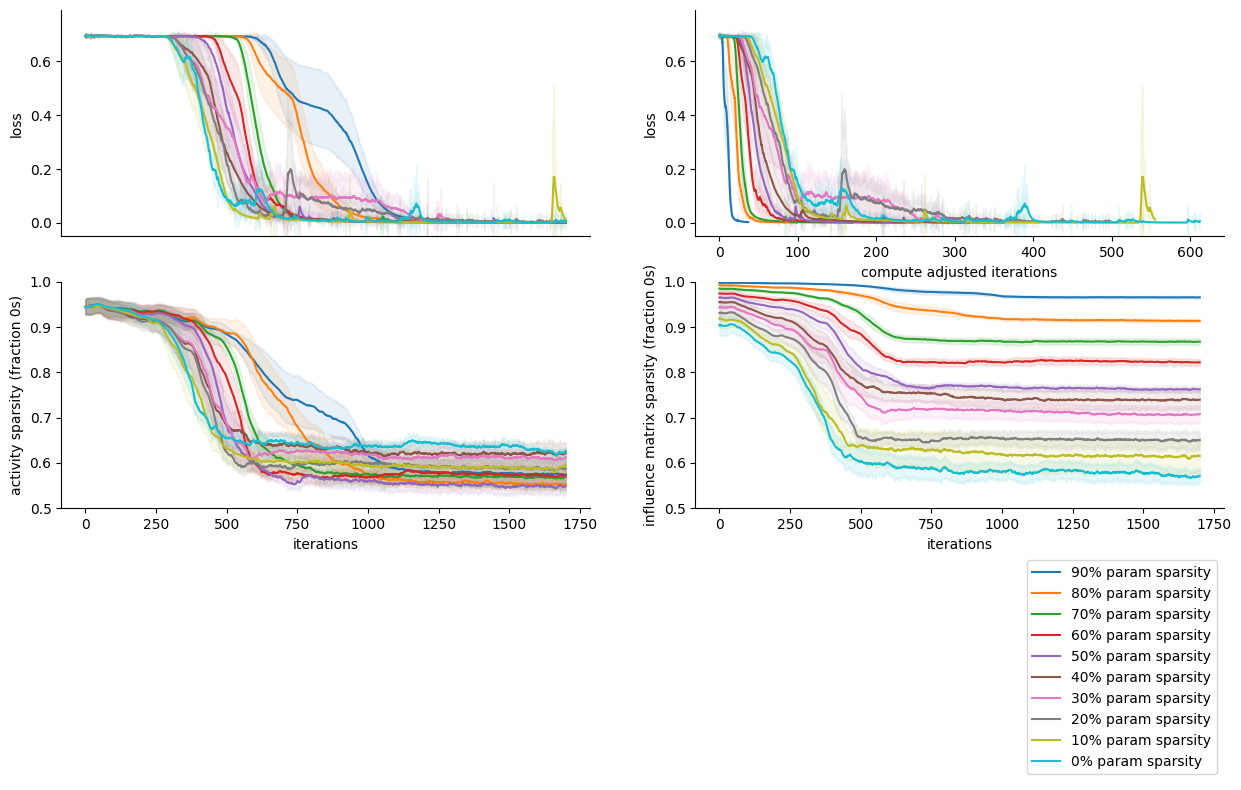

In [37]:
fname = 'activity-and-param-sparsity.svg'

fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.flatten()

ax = axs[0]
key = 'loss'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    x = sm['step']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.set(ylabel='loss', ylim=[-0.05,0.79])

ax = axs[1]
key = 'loss'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    # ax.plot(sm['cumsum_mean_M_density'], sm[key], label=f'{wsp*100:.0f}% param sparsity')
    x = sm['cumsum_mean_M_density']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylabel='loss', xlabel='compute adjusted iterations', ylim=[-0.05,0.79])


ax = axs[2]
key = 'mean_state_sparsity'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    x = sm['step']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim=[0.5, 1], xlabel="iterations", ylabel='activity sparsity (fraction 0s)')


ax = axs[3]
key = 'mean_M_sparsity'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    x = sm['step']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylim=[0.5, 1], xlabel="iterations", ylabel="influence matrix sparsity (fraction 0s)")

# fig.legend(handles, labels, bbox_to_anchor=(2, 0),loc = 'lower right')
ax = axs[4]
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax = axs[5]
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for wsp in stacked_means.keys():
    ax.plot(0, 0, label=f'{wsp*100:.0f}% param sparsity')
ax.legend()

fig.savefig(fname)

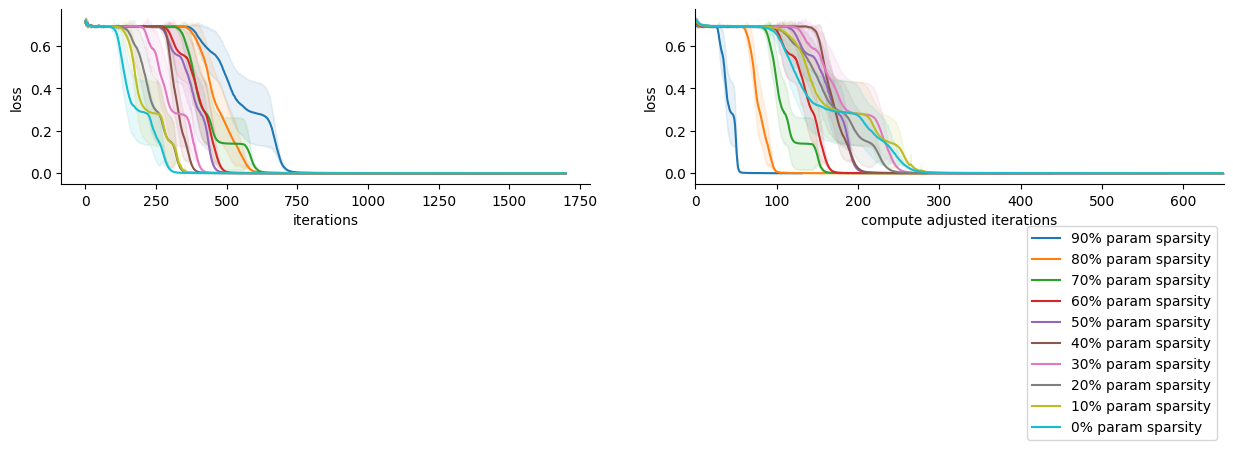

In [19]:
fname = 'only-param-sparsity.svg'

fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs = axs.flatten()

ax = axs[0]
key = 'loss'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    x = sm['step']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.set(ylabel='loss', xlabel='iterations')

ax = axs[1]
key = 'loss'
for i, (wsp, sm) in enumerate(stacked_means.items()):
    # ax.plot(sm['cumsum_mean_M_density'], sm[key], label=f'{wsp*100:.0f}% param sparsity')
    x = sm['cumsum_mean_M_density']
    y = sm[key]
    y = pd.Series(y).ewm(alpha=.1).mean()
    y_err = stacked_stds[wsp][key]/np.sqrt(5)
    ax.plot(x, y, label=f'{wsp*100:.0f}% param sparsity', color=colors[i])
    ax.fill_between(x, y - y_err, y + y_err,  alpha=0.1, interpolate=True, color=colors[i])
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylabel='loss', xlabel='compute adjusted iterations', xlim=[0,650])


# fig.legend(handles, labels, bbox_to_anchor=(2, 0),loc = 'lower right')
ax = axs[2]
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax = axs[3]
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for wsp in stacked_means.keys():
    ax.plot(0, 0, label=f'{wsp*100:.0f}% param sparsity')
ax.legend()

fig.savefig(fname)

In [ ]:
sp90['train.step']

In [ ]:
sp90['train.M_sparsity']

In [ ]:
np.cumsum(sp90['train.mean_M_sparsity'])

In [ ]:
losses, steps = [], []
psp = 0.9
for ss, ls, asp, msp in zip(sp90['train.step'], sp90['train.loss'], sp90['train.mean_state_sparsity'], sp90['train.mean_M_sparsity']):
    print(ss, ls, asp, msp)
    losses.append(ls)
    steps.append()

In [ ]:
sp90['validation.accuracy'][np.isfinite(sp90['validation.accuracy'])]